# Time Series and Forecasting Models: Facebook Prophet

# Introduction
Prophet is an open source library published by Facebook in 2017 which is built upon scikit-learn time series modelling and automatically detects changes in trends by selecting changepoints from the data. It is an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects, and includes automatic detection for all values.

# Install/import libraries

In [1]:
!pip install fbprophet
!pip install mplfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Import data

In [3]:
import yfinance as yf
ticker = "WFC"


In [4]:
df = yf.download(ticker,period='10y')

[*********************100%***********************]  1 of 1 completed


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-06-18,32.330002,32.730000,32.200001,32.459999,24.372732,20933700
2012-06-19,32.709999,33.220001,32.500000,32.959999,24.748163,30620000
2012-06-20,33.020000,33.160000,32.320000,32.810001,24.635532,29557200
2012-06-21,32.910000,33.139999,32.270000,32.340000,24.282627,31928700
2012-06-22,32.669998,33.090000,32.549999,32.810001,24.635532,34799300
...,...,...,...,...,...,...
2022-06-10,41.029999,41.439999,40.020000,40.080002,40.080002,27619300
2022-06-13,38.980000,39.680000,38.770000,38.990002,38.990002,27553800
2022-06-14,38.770000,39.299999,37.009998,37.430000,37.430000,36817600


In [6]:
df['Adj Close']

Date
2012-06-18    24.372732
2012-06-19    24.748163
2012-06-20    24.635532
2012-06-21    24.282627
2012-06-22    24.635532
                ...    
2022-06-10    40.080002
2022-06-13    38.990002
2022-06-14    37.430000
2022-06-15    38.169998
2022-06-16    37.650002
Name: Adj Close, Length: 2517, dtype: float64

# Format data for Prophet
The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [7]:
# Create a dataframe that complies with Prophet requirements

prophet_df_adj = df[['Adj Close']].copy()

In [8]:
# Reset the index back so Dates are no longer indexed
prophet_df_adj.reset_index(inplace=True)

# Rename the columns for use in FB prophet
prophet_df_adj.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

prophet_df_adj.head()

,ds,y
0,2012-06-18,24.372732
1,2012-06-19,24.748163
2,2012-06-20,24.635532
3,2012-06-21,24.282627
4,2012-06-22,24.635532


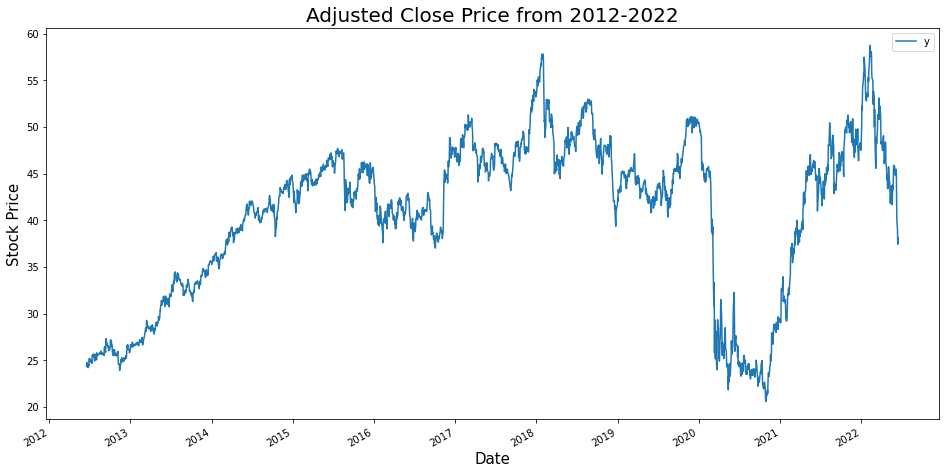

In [9]:
# Plot Adjusted Close price
pd.plotting.register_matplotlib_converters()
ax = prophet_df_adj.set_index('ds').plot(figsize=(16,8))
ax.set_title('Adjusted Close Price from 2012-2022', color = 'black', fontsize = 20)
ax.set_ylabel('Stock Price', color = 'black', fontsize = 15)
ax.set_xlabel('Date', color = 'black', fontsize = 15)

plt.show()

# Modelling
Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

# Fit and train the model
Fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor.

In [10]:
# Instantiate model and pass seasonality setting

m = Prophet(daily_seasonality = True)

In [11]:
#Call the fit method and pass in the dataframe of dates and prices.
# fit the model

m.fit(prophet_df_adj)


# Create future dates to forecast
Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe.

In [12]:
# create a dataframe containing future dates to be forecast 
future = m.make_future_dataframe(periods=730, freq='D')     
future.tail()

,ds
3242,2024-06-11
3243,2024-06-12
3244,2024-06-13
3245,2024-06-14
3246,2024-06-15


# Predictions
Forecasting future values in the dataframe containing dates for prediction.

In [13]:
# Pass the dataframe to the model with dates to predict future values
forecast = m.predict(future)

# Plot Actual vs Predicted prices

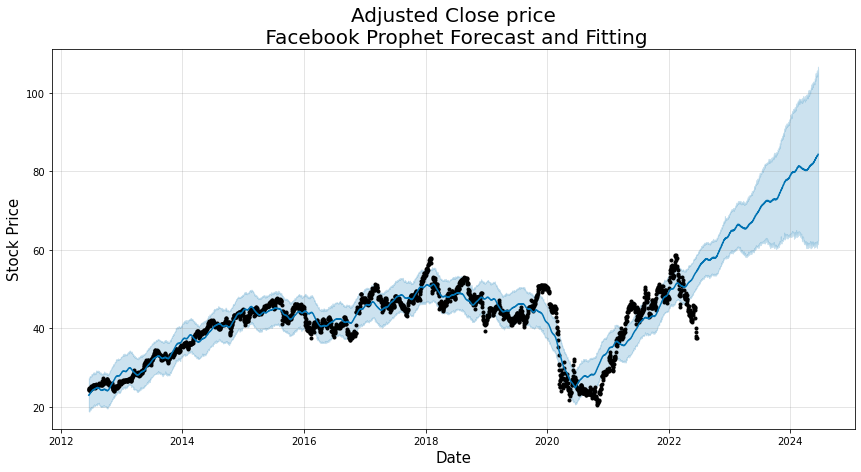

In [14]:
# Plot Forecast and Actual prices  
m.plot(forecast, uncertainty=True, figsize=(12,6))
plt.title('Adjusted Close price\n Facebook Prophet Forecast and Fitting', color = 'black', fontsize = 20)
plt.xlabel("Date", color = 'black', fontsize = 15)
plt.ylabel("Stock Price", color = 'black', fontsize = 15)
plt.show()

In the above plot:

* Blue line = Forecasted values
* Black dots = Observed (actual) values
* Blue-shaded region = Confidence interval

# Trend Changepoints

Time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.

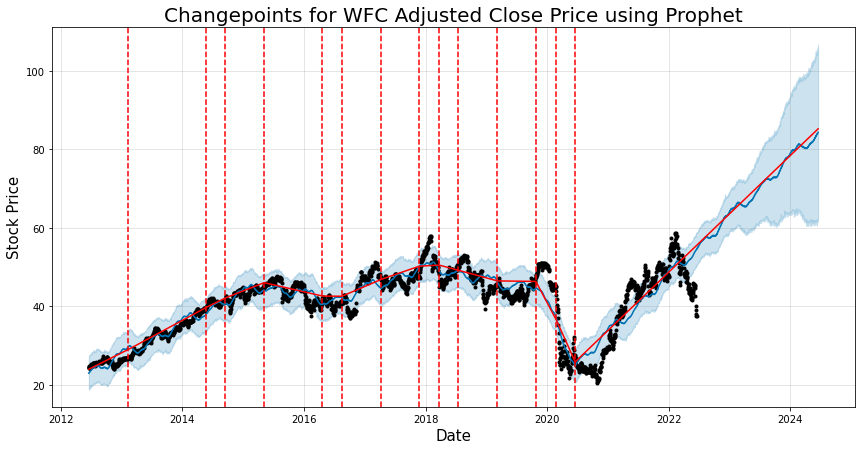

In [15]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast, figsize=(12,6))
# the change points are added to our plot 
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title("Changepoints for WFC Adjusted Close Price using Prophet", color = 'black', fontsize = 20)
plt.xlabel("Date", color = 'black', fontsize = 15)
plt.ylabel("Stock Price", color = 'black', fontsize = 15)
plt.show()

By default, Prophet adds 25 changepoints into the initial 80% of the data set. Taking a look at the possible changepoints (dotted red lines) in the above chart, we can see they fit quite well with some of the highs and lows.

# Plot magnitudes of changepoints
Prophet will also let us take a look at the magnitudes of these possible changepoints.

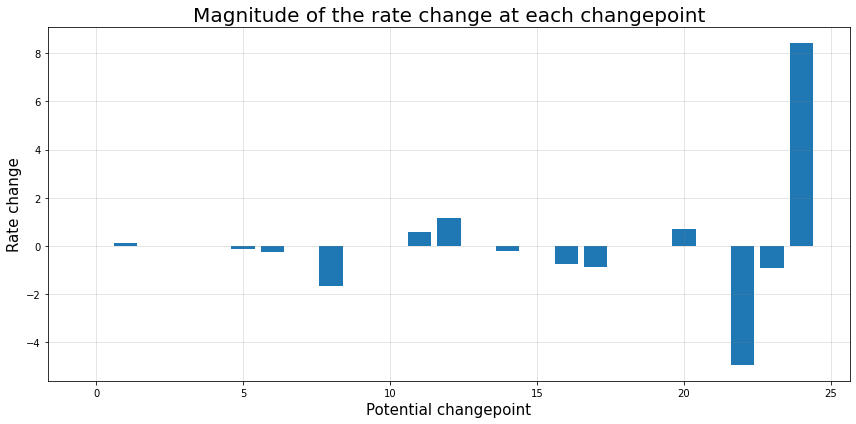

In [16]:
deltas = m.params['delta'].mean(0) 
fig = plt.figure(facecolor='w', figsize=(12,6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.title('Magnitude of the rate change at each changepoint', color = 'black', fontsize = 20)
ax.set_ylabel('Rate change', color = 'black', fontsize = 15)
ax.set_xlabel('Potential changepoint', color = 'black', fontsize = 15)
fig.tight_layout()

We can see that the red dotted lines in the plot of changepoints correspond with plot above of the magnitude of the rate change at each changepoint. Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused

# Extract changepoints

If we want to use something like this in a model, we need a way of extracting changepoint data.

In [17]:
# View changepoints

m.changepoints

80     2012-10-10
161    2013-02-08
241    2013-06-05
322    2013-09-30
402    2014-01-24
483    2014-05-21
563    2014-09-15
644    2015-01-09
724    2015-05-06
805    2015-08-31
885    2015-12-23
966    2016-04-21
1046   2016-08-15
1127   2016-12-08
1207   2017-04-05
1288   2017-08-01
1368   2017-11-22
1449   2018-03-22
1529   2018-07-17
1610   2018-11-08
1690   2019-03-08
1771   2019-07-03
1851   2019-10-25
1932   2020-02-24
2012   2020-06-17
Name: ds, dtype: datetime64[ns]

# Plot components of the forecasts

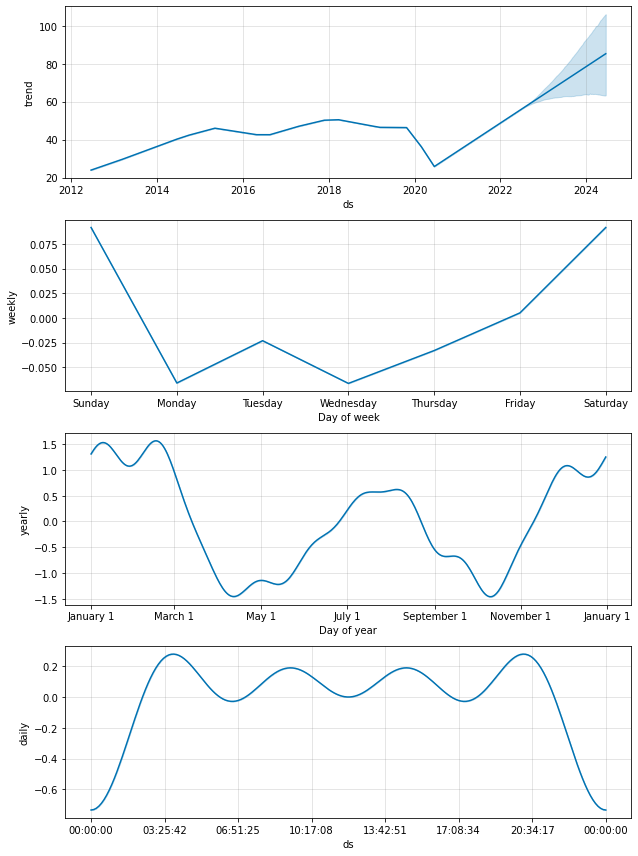

In [18]:
# Plot the trend, weekly, yearly and daily components

m.plot_components(forecast)
plt.show()

Our data has some seasonal information present. Based on the estimated trends, we can see from the yearly subplot that, usually, the stock price is highest in early-January and, according to the weekly subplot, mostly on Saturdays. Inevitably, the daily subplot shows that the stock price fluctuates throughout the day.

Finally, the trend subplot shows an upward trend including an increase in the stock price between mid 2020 and beginning of 2022). The dataset only contained data up to the end of 2019 so this prediction does not reflect any impact of Covid-19.